# 🔎 Full model evaluation using MLFlow

When we **evaluate** a model, we want to **measure its performance and understand how accurate it is** in making predictions. MLflow allows us to log different parameters, such as accuracy, precision, recall, and others, which help us understand how well the model is doing. It's like keeping score to see if the model is getting better or not.

Additionally, **MLflow allows us to save artifacts, which are files or resources that provide additional insights into the model's performance**. These artifacts can include things like plots, charts, or even the trained model itself. It's like having a folder where we can save useful things related to the model.

By logging parameters and saving artifacts with MLflow, we can **easily keep track of the model's evaluation results** and have all the necessary files in one place. This makes it easier to analyze the model's performance, share the evaluation results with others, and compare different versions of the model. It's like having a report card and a folder of useful materials to understand how good the model is and improve it if needed.

In [1]:
import mlflow
from mlops_course.settings import config
from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from datetime import datetime
import pandas as pd
import seaborn as sns


## Get Evaluation Data

In [2]:
RANDOM_SEED = 42  # Set a random seed for reproducibility
TEST_SIZE = 0.2  # 20% of the data will be used for testing
DATASET_URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

# Load dataset
dataframe = pd.read_csv(DATASET_URL)

# Fill missing values
age_mean = dataframe['Age'].mean()
dataframe['Age'].fillna(age_mean, inplace=True)
embarked_mode = dataframe['Embarked'].mode()[0]
dataframe['Embarked'].fillna(embarked_mode, inplace=True)

# convert string labels to numbers: male=1, female=0, embarked_C=0, embarked_Q=1, embarked_S=2
le = LabelEncoder()
dataframe["Sex"] = le.fit_transform(dataframe["Sex"])
dataframe["Embarked"] = le.fit_transform(dataframe["Embarked"])

# Prepare the dataset for training
features = ['Sex', 'Age', 'Fare', 'Embarked']
X = dataframe[features]
Y = dataframe['Survived']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

### Visualize the Data

Now let's visualize the relationship between various features and the target variable, 'Survived'.

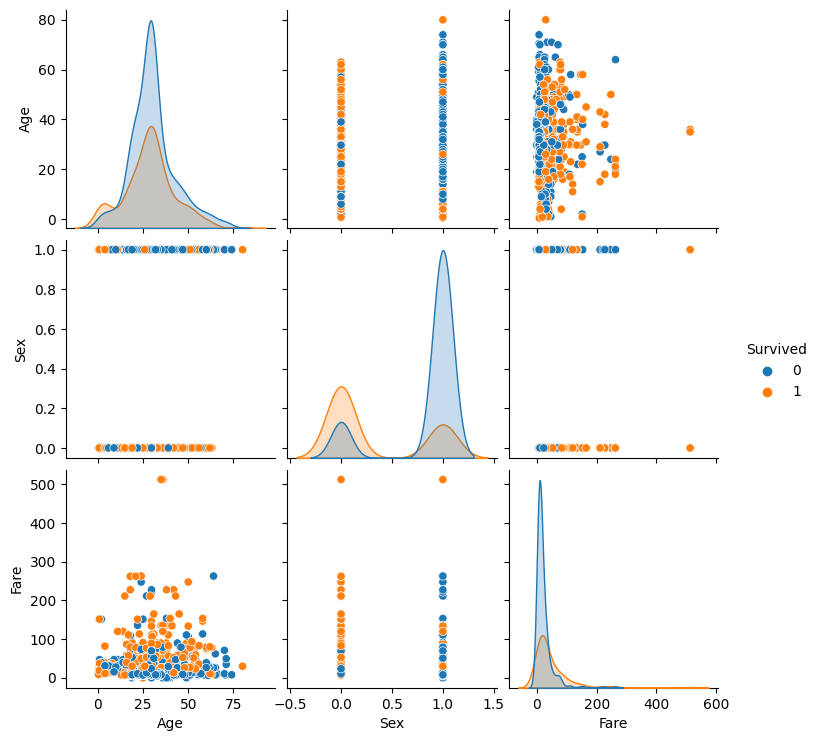

In [3]:
sns.pairplot(dataframe[["Age", "Sex", "Fare", "Survived"]], hue="Survived")

### Train the model

In [4]:
# Train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

### Test the model

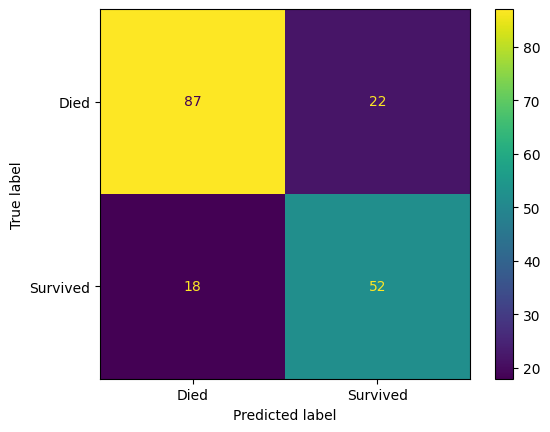

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# generate the confusion matrix plot
y_pred = model.predict(X_test)  # predict the test data
confusion_matrix_pred = confusion_matrix(y_pred, y_test)
confusion_matrix_plot = ConfusionMatrixDisplay(confusion_matrix_pred, display_labels=['Died', 'Survived']).plot()

### Connect to the MLflow server

In [6]:
# Set the URI where the MLflow server is running
mlflow.set_tracking_uri(uri=config.MLFLOW_TRACKING_URI)

/usr/local/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Run ID: a902eaf4dfd64a29adc891ee574363b3


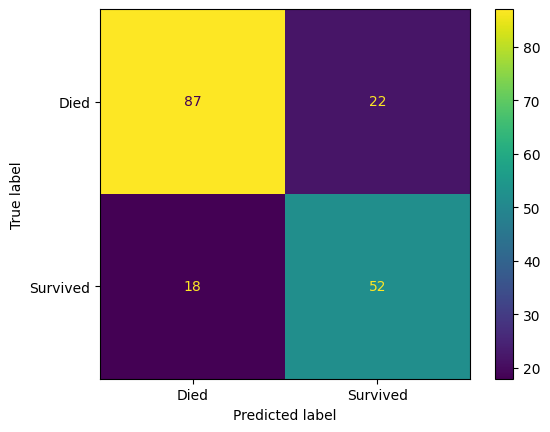

In [7]:
EXPERIMENT_NAME = "Titanic Linear Regression"  # change this to your experiment name


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
run_name = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with mlflow.start_run(
    experiment_id=experiment_id,
    run_name=run_name,
) as run:

    # Log the model parameters
    mlflow.log_param("model_name", "Logistic Regression")
    mlflow.log_param("random_seed", RANDOM_SEED)
    mlflow.log_param("test_size", TEST_SIZE)

    # Train the logistic regression model
    model = LogisticRegression(random_state=RANDOM_SEED)
    model.fit(X_train, y_train)
    mlflow.sklearn.log_model(model, "model")  # log the model itself

    # Make predictions on the test set and compute metrics
    y_pred = model.predict(X_test)
    precision = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # Create a plot with the confusion matrix and log it as an artifact
    confusion_matrix_pred = confusion_matrix(y_pred, y_test)
    confusion_matrix_plot = ConfusionMatrixDisplay(confusion_matrix_pred, display_labels=['Died', 'Survived']).plot()
    mlflow.log_figure(confusion_matrix_plot.figure_, "confusion_matrix.png")

    # Print the run ID
    print(f"Run ID: {run.info.run_id}")